In [0]:
#!pip install -q tf-nightly

In [0]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os 
import pickle
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# os.chdir("drive/My Drive/Code _ Data/6.new_data") 
os.chdir("drive/My Drive/Online Lending/Sequential Embedding/Spring 2020/Final Submission/Data/high_income_data/processed") # give the path to the data file.
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['features_sequential_embedded.json',
 'label.json',
 'non_sequential_features.json',
 'featurematrix.json',
 'padded_sequential_features.json',
 'embedding_sequence.p',
 'stay_time_sequence.p',
 'checkpoints']

# Setup Input

In [0]:
with open('label.json') as f:
    labels = json.load(f)
with open('embedding_sequence.p', 'rb') as f:
    embedding_sequence = pickle.load(f)
with open('stay_time_sequence.p', 'rb') as f:
    stay_time_sequence = pickle.load(f)
label = np.array([[labels[key]] for key in labels.keys()], dtype=np.float32)
embedding_sequence = np.array(embedding_sequence, dtype=np.float32)
stay_time_sequence = np.array(stay_time_sequence, dtype=np.float32)
stay_time_sequence = stay_time_sequence.reshape(-1, 60, 1)
labels.keys()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
stay_time_sequence.shape

(149923, 60, 1)

In [0]:
embedding_sequence.shape

(149923, 60, 50)

In [0]:
label.shape

(149923, 1)

# Train Test Split

In [0]:
train_behavior, test_behavior, train_stay_time, test_stay_time, train_label, test_label = train_test_split(
    embedding_sequence, stay_time_sequence, label, test_size=0.1)
train_behavior.shape, train_stay_time.shape, train_label.shape

((134930, 60, 50), (134930, 60, 1), (134930, 1))

# Set Hyperparameters

In [0]:
#num_layers = 4
#d_model = 128
#dff = 512
#num_heads = 8

#input_size = 149923
#target_size = 149923
# dropout_rate = 0.1
batch_size = 64
learning_rate = 0.01

# Positional Encoding

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


# Multi-head Attention Layer

In [0]:
#In this architecture, we choose to construct without mask 
def scaled_dot_product_attention(q, k, v):
  """
  Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  #if mask is not None:
  #  scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

# Feed-forward Network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation="relu"),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder Layer

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training):

    attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(x + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [0]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 60, 512)), False)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 60, 512])

# Decoder Layer

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    # self.ffn1 = point_wise_feed_forward_network(d_model, dff)
    self.ffn2 = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # ffn_output1 = self.ffn1(x)  # (batch_size, input_seq_len, d_model)
    # ffn_output1 = self.dropout1(ffn_output1, training=training)
    # out1 = self.layernorm1(x + ffn_output1)  # (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output2 = self.ffn2(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output2 = self.dropout3(ffn_output2, training=training)
    out3 = self.layernorm3(ffn_output2 + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block2

In [0]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training)
    
    return x  # (batch_size, input_seq_len, d_model)

In [0]:
sample_encoder = Encoder(num_layers=2, d_model=50, num_heads=10, dff=2048, maximum_position_encoding=60)
temp_input = tf.random.uniform((64, 60, 50), dtype=tf.float32, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 60, 50)


# Decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    #self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    #x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block2 = self.dec_layers[i](x, enc_output, training)
      
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [0]:
sample_decoder = Decoder(num_layers=2, d_model=50, num_heads=5, dff=2048, maximum_position_encoding=60)
temp_input = tf.random.uniform((64, 26, 50), dtype=tf.float32, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,enc_output=sample_encoder_output,training=False)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 50]), TensorShape([64, 5, 26, 60]))

# Transformer

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, target_size, maximum_position_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, maximum_position_encoding, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, maximum_position_encoding, rate)

    self.final_layer1 = tf.keras.layers.Dense(target_size)
    self.final_layer3 = tf.keras.layers.Dense(1, activation = "sigmoid")
    
  def call(self, inp, tar, training, batch_size):

    enc_output = self.encoder(inp, training)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training)
    
    final_output1 = self.final_layer1(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    final_output2 = tf.reshape(final_output1, (batch_size, -1))
    final_output3 = self.final_layer3(final_output2)
    return final_output3, attention_weights
sample_transformer = Transformer(num_layers=2, d_model=50, num_heads=10, dff=512, target_size=60, maximum_position_encoding=60)

In [0]:
tf.executing_eagerly() 

True

In [0]:
sample_transformer = Transformer(num_layers=2, d_model=50, num_heads=10, dff=512, target_size=60, maximum_position_encoding=60)

#temp_input = tf.random.uniform((100,60,50), dtype=tf.float32, minval=0, maxval=200)
#temp_target = tf.random.uniform((100,60,1), dtype=tf.float32, minval=0, maxval=200)
fn_out, _ = sample_transformer(embedding_sequence[:32], stay_time_sequence[:32], training=False, batch_size=32)

# fn_out, _ = sample_transformer(temp_input, temp_target, training=False)

fn_out  # (batch_size, tar_seq_len, target_vocab_size)

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.5590977 ],
       [0.56253517],
       [0.5634813 ],
       [0.59959376],
       [0.56450486],
       [0.5343397 ],
       [0.5762417 ],
       [0.6645876 ],
       [0.54990107],
       [0.5670042 ],
       [0.5374921 ],
       [0.5686124 ],
       [0.47458327],
       [0.43931648],
       [0.5491694 ],
       [0.5294906 ],
       [0.5370212 ],
       [0.51806325],
       [0.48748764],
       [0.59075475],
       [0.589478  ],
       [0.5547391 ],
       [0.5775752 ],
       [0.5576585 ],
       [0.5564946 ],
       [0.55572504],
       [0.5984175 ],
       [0.629127  ],
       [0.5670979 ],
       [0.5594499 ],
       [0.5750337 ],
       [0.45594856]], dtype=float32)>

# Optimizer

In [0]:
learning_rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate, epsilon=1e-9)

In [0]:
# d_model=50

# loss

In [0]:
def loss_function(y_true, y_pred):
  # dot_product = y*tf.log(output)
  # xentropy = -tf.reduce_sum(dot_product, reduction_indices=1)
  # loss = tf.reduce_mean(xentropy)
#   bce = tf.keras.losses.BinaryCrossentropy()
#   loss = bce(y_true, y_pred)

  sfce = tfa.losses.SigmoidFocalCrossEntropy()
  loss = sfce(y_true, y_pred)

  return loss

# Evaluation

In [0]:
# def evaluate(output, y):
#     """
#     evaluates the accuracy on the validation set 
#     input:
#         -output: prediction vector of the network for the validation set
#         -y: true value for the validation set
#     output:
#         - accuracy: accuracy on the validation set (scalar between 0 and 1)
#     """
#     #correct prediction is a binary vector which equals one when the output and y match
#     #otherwise the vector equals 0
#     #tf.cast: change the type of a tensor into another one2
#     #then, by taking the mean of the tensor, we directly have the average score, so the accuracy
    
#     correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     tf.summary.scalar("validation_error", (1.0 - accuracy))
#     return accuracy

# Main Function

In [0]:
def data_generator(x1, x2, y, batch_size=32):
  while True:
    total_batch = len(y)//batch_size
    # if total_batch < len(y)/batch_size:
    #   total_batch += 1
    batch_ind = 0
    while batch_ind < total_batch:
      start = batch_ind * batch_size
      end = (batch_ind + 1) * batch_size
      batch_ind += 1
      yield x1[start:end], x2[start:end], y[start:end]
# g = data_generator(x1,x2,y)
# next(g)

In [0]:
x1 = train_behavior[:]
x2 = train_stay_time[:]
y = train_label[:]

In [0]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=sample_transformer,optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(batch_size, 60, 50), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, 60, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, 1), dtype=tf.float32)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp1, inp2, tar):
  
  with tf.GradientTape() as tape:
    predictions, _ = sample_transformer(inp1, inp2, True, batch_size)
    loss = loss_function(tar, predictions)

  gradients = tape.gradient(loss, sample_transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, sample_transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar, predictions)
  train_AUC(tar, predictions)
  # print(predictions[:10])

In [0]:
EPOCHS = 8
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
train_AUC = tf.keras.metrics.AUC(name='train_AUC')
# optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer = tf.keras.optimizers.Adam()
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_AUC.reset_states()
  total_batch = int(len(x1)/batch_size)
  # if total_batch < len(y)/batch_size:
  #   total_batch += 1
  data = data_generator(x1, x2, y, batch_size)
  for batch_ind in range(total_batch): 
    minibatch_x1, minibatch_x2, minibatch_y = next(data)
    train_step(minibatch_x1, minibatch_x2, minibatch_y)
    if batch_ind % 10 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f} AUC {:.4f}'.format(
          epoch + 1, batch_ind, train_loss.result(), train_accuracy.result(), train_AUC.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(),train_accuracy.result()))
  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1461 Accuracy 0.5469 AUC 0.4836
Epoch 1 Batch 10 Loss 0.0991 Accuracy 0.8636 AUC 0.4989
Epoch 1 Batch 20 Loss 0.1155 Accuracy 0.8891 AUC 0.4945
Epoch 1 Batch 30 Loss 0.0897 Accuracy 0.9068 AUC 0.4639
Epoch 1 Batch 40 Loss 0.0778 Accuracy 0.9108 AUC 0.4756
Epoch 1 Batch 50 Loss 0.0681 Accuracy 0.9157 AUC 0.4740
Epoch 1 Batch 60 Loss 0.0622 Accuracy 0.9162 AUC 0.4894
Epoch 1 Batch 70 Loss 0.0570 Accuracy 0.9186 AUC 0.4946
Epoch 1 Batch 80 Loss 0.0537 Accuracy 0.9192 AUC 0.4956
Epoch 1 Batch 90 Loss 0.0506 Accuracy 0.9208 AUC 0.4972
Epoch 1 Batch 100 Loss 0.0483 Accuracy 0.9220 AUC 0.4979
Epoch 1 Batch 110 Loss 0.0465 Accuracy 0.9222 AUC 0.4979
Epoch 1 Batch 120 Loss 0.0446 Accuracy 0.9236 AUC 0.4980
Epoch 1 Batch 130 Loss 0.0433 Accuracy 0.9241 AUC 0.4979
Epoch 1 Batch 140 Loss 0.0421 Accuracy 0.9249 AUC 0.5004
Epoch 1 Batch 150 Loss 0.0409 Accuracy 0.9255 AUC 0.5026
Epoch 1 Batch 160 Loss 0.0403 Accuracy 0.9254 AUC 0.5017
Epoch 1 Batch 170 Loss 0.0398 Accuracy 0.9

# Evaluate

In [0]:
test_predictions, _ = sample_transformer(test_behavior, test_stay_time, True, len(test_label))

In [0]:
train_AUC.reset_states()
train_AUC.update_state(test_label,test_predictions)
auc = train_AUC.result().numpy()
print("AUC result:", auc)

AUC result: 0.5616562


In [0]:
train_accuracy.update_state(test_label, test_predictions)
accuracy = train_accuracy.result().numpy()
print("Accuracy:", accuracy)

Accuracy: 0.93245053


In [0]:
fpr, tpr, threshold = roc_curve(test_label, test_predictions)
ks = (tpr-fpr)
max_ = np.argmax(ks)
print("KS:", ks)

0.10732105194471692

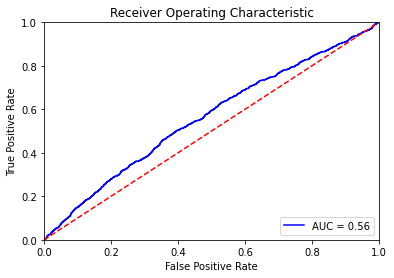

In [0]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()